# Predicting Air Quality with Economic Data

#### Noah Kupinsky

## Movitavtion

### The Issue of Air Quality

Air quality is an issue that's becoming harder to ignore. Every year, it seems like the air we breathe is getting a bit worse, with global studies showing that 90% of the world's population is exposed to unhealthy air quality [WHO Report](https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health). Factories, cars, and other sources of pollution are major contributors to this decline. It’s not just about the environment —- poor air quality directly affects our health, contributing to respiratory problems, heart disease, and more.

### Why Economic Data?

In tandem with rising pollution levels, and perhaps even preceeding it, we've seen more innovation, energy consumption, and production from countries. It makes some intuitive sense that economic indicators might be useful for predicting air quality. For one, more factories usually mean more emissions. If a country's GDP is rising, it's often because industrial output is ramping up, leading to more pollutants being released into the atmosphere. Similarly, a higher GDP per capita often means more cars on the road, contributing to higher levels of air pollution. By analyzing these economic indicators, we can potentially get insight into air quality trends. To be expected, there's considerable research already out there on this. You can check out a relationship found between carbon emissions and inflation [here](https://www.frontiersin.org/articles/10.3389/fenvs.2023.1093528/full). A natural question would be to ask about the other direction: how does air quality influence a country's economy? We won't be looking into that, but the curious reader has many [options](https://www.clarity.io/blog/a-deep-dive-economic-impacts-of-air-pollution) to explore.

### Implications

Beyond just establishing correlation and being cool, this kind of data analysis might also be useful from a policy-making perspective. If one can show that economic indicators reliably predict air quality, it gives governments and organizations a powerful tool. They can plan and implement policies more effectively, balancing economic growth with environmental sustainability. For instance, if we know a sudden spike in industrial output is likely to, in turn, spike pollution levels, policies could be put in place to mitigate those effects beforehand. On the other hand, if a country notices that their pollution is relatively uncoupled to its economic growth, then it knows it's doing a good job with environmental policy.



## Air Quality Data

Let's get started by collecting and processing some air quality data. There are many options for where to get said data from, with [openAQ](https://openaq.org/) providing remarkable specifics, but for this project, all we'll be using is aggregate annual data, so I'll be pulling from the [WHO's Ambient Air Quality Database](https://www.who.int/publications/m/item/who-ambient-air-quality-database-(update-jan-2024)). I have the file saved in the same directory as this notebook, as "air_quality_data.xlsx". 

**We'll start with some setup code. We're using openpyxl to open the excel spreadsheet, here.**


In [135]:
%%capture
%pip install openpyxl

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
import requests
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=UserWarning)

In [137]:
START_YEAR = 2010
END_YEAR = 2023
AQ_SPREADSHEET = "air_quality_data.xlsx"
AQ_SHEET_NAME = "Update 2024 (V6.1)"
aq_df = pd.read_excel(AQ_SPREADSHEET, sheet_name=AQ_SHEET_NAME)

### Metrics

The three metrics we'll be looking at are PM2.5, PM10, and NO2 concentrations because they are key indicators of air pollution with significant health impacts. PM2.5 and PM10 refer to particulate matter of different sizes, with PM2.5 being fine particles that can penetrate deep into the lungs and even enter the bloodstream, and PM10 being slightly larger particles that can cause respiratory issues. NO2, nitrogen dioxide, is a harmful gas emitted from vehicles and industrial activities, contributing to respiratory problems and the formation of other pollutants too. By analyzing these pollutants, we can get a hollistic understanding of a country's air quality

We'll also need to grab the country and the year from each row. The country is stored as an iso3 code, which is just a standardized 3-letter code for the country. This is super convenient, because the place we're pulling economic data from also happens to use iso3 codes. Go us!

**Let's go ahead and get our desired columns from the data**

In [138]:
POLLUTANTS = ["pm10", "pm25", "no2"]

aq_df = aq_df[["iso3", "year", "pm10_concentration", "pm25_concentration", "no2_concentration"]]
# fix NaN operation errors - a little weird looking but necessary
aq_df["year"] = aq_df['year'].astype(float).astype("Int32")
# rename columns appropriately
rename_dict = {(x + "_concentration"): x for x in POLLUTANTS}
rename_dict['iso3'] = 'country'
aq_df = aq_df.rename(columns=rename_dict)

print(aq_df.head(5))

  country  year    pm10    pm25     no2
0     ESP  2013  23.238  11.491  28.841
1     ESP  2014  27.476  15.878  19.575
2     ESP  2015  25.515  14.004  22.731
3     ESP  2016  23.057  13.160  20.204
4     ESP  2017  26.849  14.114  21.543


Each row of the table actually corresponds to a measurement in a city of a specific country in a specific year, so we'll take the mean across cities for each country/year pair.

In [139]:
aq_df = aq_df.groupby(['country', 'year'], as_index=False).mean()

Having three metrics is lovely, but ultimately, we do want to predict a single air quality metric, so we need some way to standardize these metrics, and a way to pick from the three standardized values. Thankfully, the air community has already figured out how to do this. There are [breakpoints](https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html) (not the code kind) for each pollutant, given by the US EPA that denote a relationship between concentrations of the pollutant, and sections of the 0 - 500 AQI spectrum. We can use [available literature](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) to calculate these AQI values, and then take the maximum (== most severe pollution).

**Let's code some breakpoints**

In [140]:
# Breakpoints for AQI calculation
BREAKPOINTS = {
    "pm25": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.4, 301, 500),
    ],
    "pm10": [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 604, 301, 500),
    ],
    "no2": [
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 2049, 301, 500),
    ]
}

def calculate_aqi(concentration, breakpoints):
    for C_low, C_high, I_low, I_high in breakpoints:
        if C_low <= concentration <= C_high:
            return ((I_high - I_low) / (C_high - C_low)) * (concentration - C_low) + I_low
    return np.nan

def calculate_aqi_for_row(row):
    aqis = list(map(lambda p: calculate_aqi(row[p], BREAKPOINTS[p]) if not np.isnan(row[p]) else np.nan, POLLUTANTS))
    return max(aqis, key=lambda x: -np.inf if np.isnan(x) else x)

aq_df['aqi'] = aq_df.apply(lambda row: calculate_aqi_for_row(row), axis=1)
# we won't need the specific pollutants anymore
aq_df = aq_df[['country', 'year', 'aqi']]
aq_df = aq_df.dropna()
print(aq_df.head(5))


  country  year         aqi
0     AFG  2019  184.186786
1     ALB  2014   52.705011
2     ALB  2015   59.949861
3     ALB  2016   60.984013
4     ALB  2017   62.343079


Let's take a look at what we've got here. To get a sense of the trend of the data, graph it over time. We'll pick out a few countries to take a look at specifically, and then graph them too. I imagine we'll see worsening air quality over time, but who knows.

**Let's make a line graph of aqi over time, by country**

In [141]:
BIG_DOGS = ['USA', 'CHN', 'RUS', 'DEU', 'GBR', 'FRA', 'JPN', 'IND', 'BRA', 'ITA']

def plot_country_metric_over_time(df, y_col, countries=None, with_legend=False):
    countries = countries or df['country'].unique()
    # create subplots for each country
    fig, ax = plt.subplots()
    for country in countries:
        # sort and then plot data
        country_data = df[df['country'] == country].sort_values(by='year')
        ax.plot(country_data['year'], country_data[y_col], marker='o', label=country)
    # make things pretty
    ax.set_xlabel('Year')
    ax.set_ylabel(y_col)
    ax.set_title(f'{y_col} Over Time by Country')
    if (with_legend):
        ax.legend()
    plt.show()

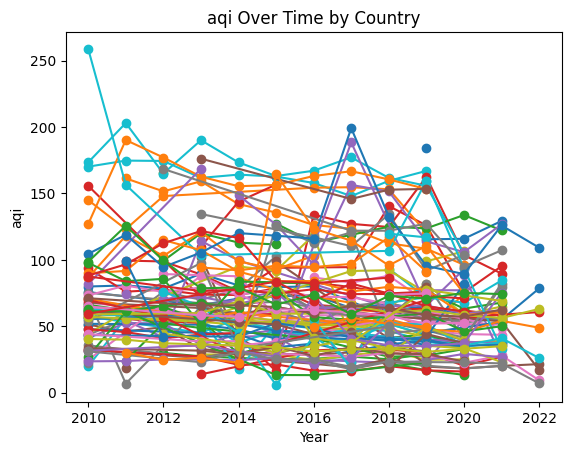

In [142]:
plot_country_metric_over_time(aq_df, 'aqi') 

Interestingly, it appears that despite the long term trend being worsening air quality, in recent past (last 10 years or so), it seems air quality is largely improving worldwide. This is exciting because the relationship between economy and air quality will surely not be as simple as economy goes up, air quality goes down now. My initial hypothesis may have been wrong, but from a data science perspective this is more fun now.

**Let's look at some specific countries now**
- United States
- China
- Russia
- Germany
- UK
- France
- Japan
- India
- Brazil
- Italy

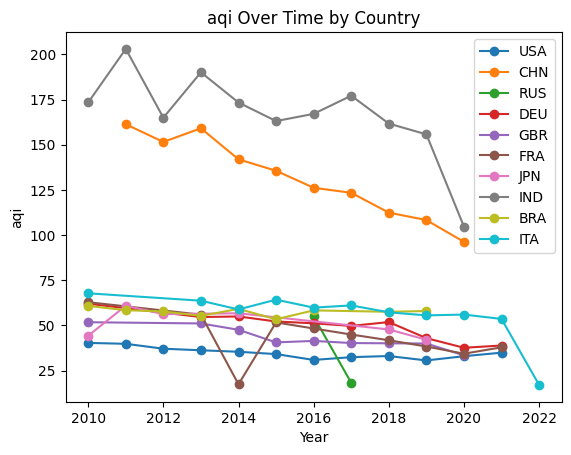

In [143]:
plot_country_metric_over_time(aq_df, 'aqi', countries=BIG_DOGS, with_legend=True)

## Indicators

Now let's move on to economic indicators. We're interested in both how gross economic output relates to air quality, as well as per-capita and per-sq-km metrics, because people in a country present a motivation for creating pollution, and land area presents a constraint. We'll be getting our data from the [World Bank API](https://documents.worldbank.org/en/publication/documents-reports/api).

### Basic Data

Our basic indicators will just be population and land area. I don't suspect land area to change in a meaningful way over time in relation to air quality (lol) so I'll keep that one constant. Before we get into exploring this data, we have to actually wrangle the world bank data into a df.

#### Fetching World Bank Data

**The data comes in pages, so we keep making get requests until there are no more pages of data left for us to read.**

In [144]:

def fetch_world_bank_pages(indicator, start_year, end_year):
    all_data = []
    page = 1
    while True:
        url = f'http://api.worldbank.org/v2/country/all/indicator/{indicator}?date={start_year}:{end_year}&format=json&per_page=2000&page={page}'
        response = requests.get(url)
        data = response.json()
        # data is stored in second element of returned array, if it exists
        if len(data) < 2 or not data[1]:
            break
        all_data.extend(data[1])
        page += 1
    # the column with the iso3 code is "countryiso3code", not "country", so we can get rid of "country"
    return pd.DataFrame(all_data).drop(columns=['country'])

def fetch_world_bank_data(indicator, column_name, start_year=START_YEAR, end_year=END_YEAR):
    # get pages based on indicator
    df = fetch_world_bank_pages(indicator, start_year, end_year)
    # get the year from each date
    df['year'] = pd.to_datetime(df['date'], utc=True).dt.year
    # rename the columns to what we expect
    df = df.rename(columns={'countryiso3code': 'country', 'value': column_name})
    # drop duplicates and return the columns of interest
    df.drop_duplicates(subset=['country', 'year'], inplace=True)
    df = df[['country', 'year', column_name]].dropna()
    return df

# API Indicators
INDICATORS = {
    "population": 'SP.POP.TOTL',
    "land_area": 'AG.LND.TOTL.K2',
    "gdp": 'NY.GDP.MKTP.CD',
    "growth_rate": 'NY.GDP.MKTP.KD.ZG',
    "industrial_output": 'NV.IND.MANF.CD'
}

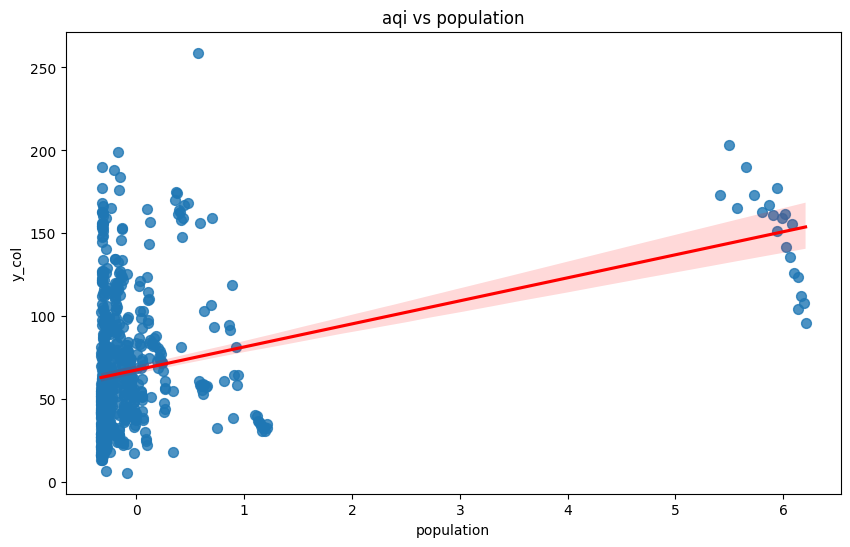

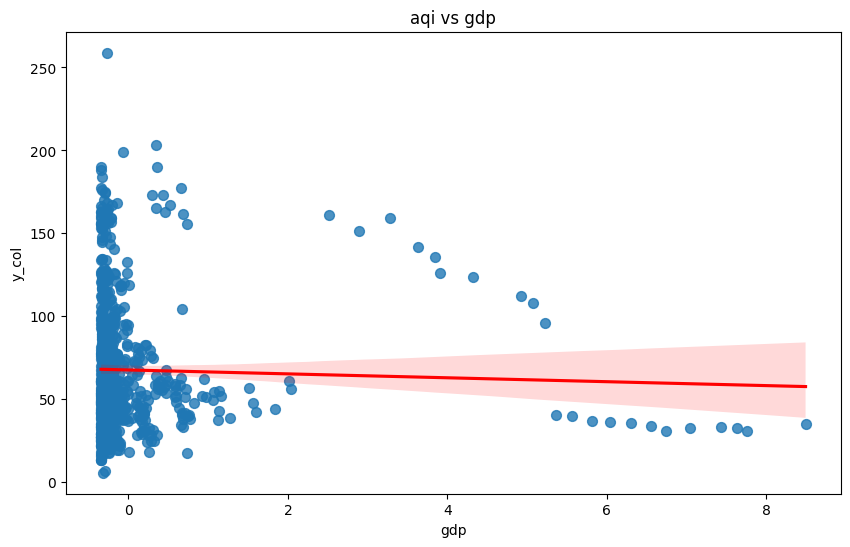

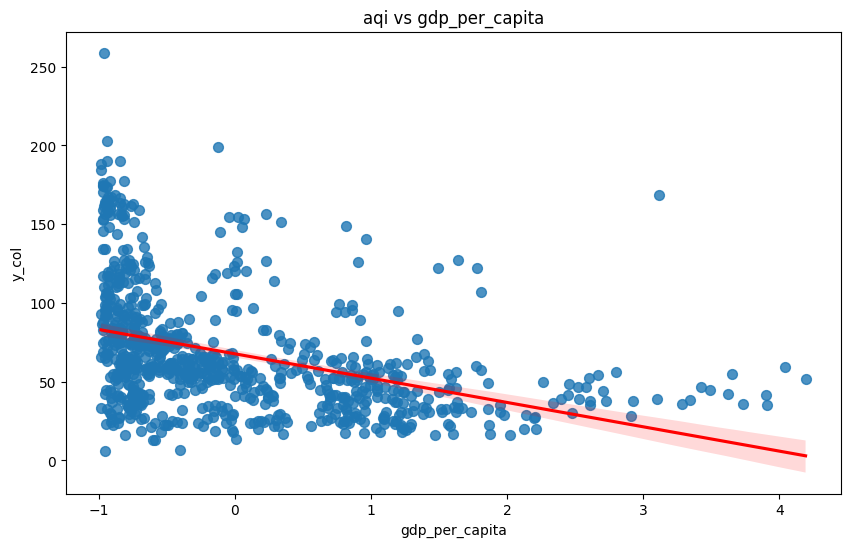

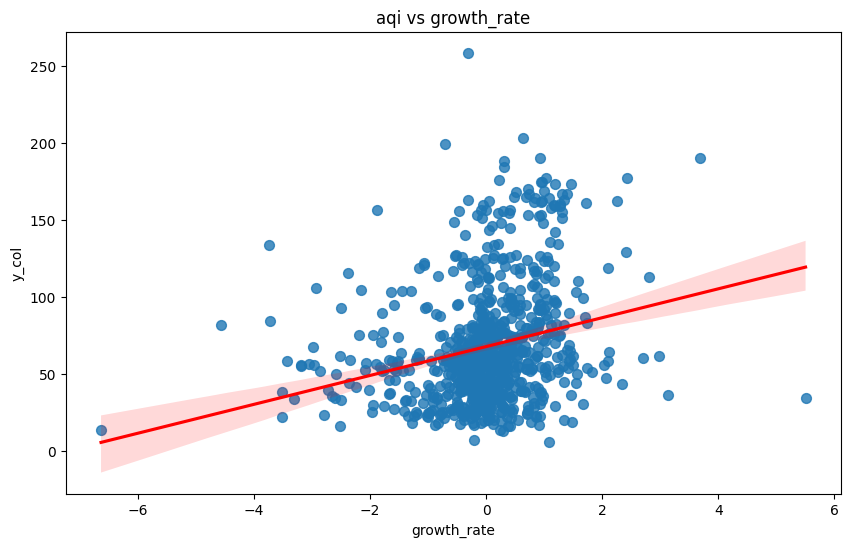

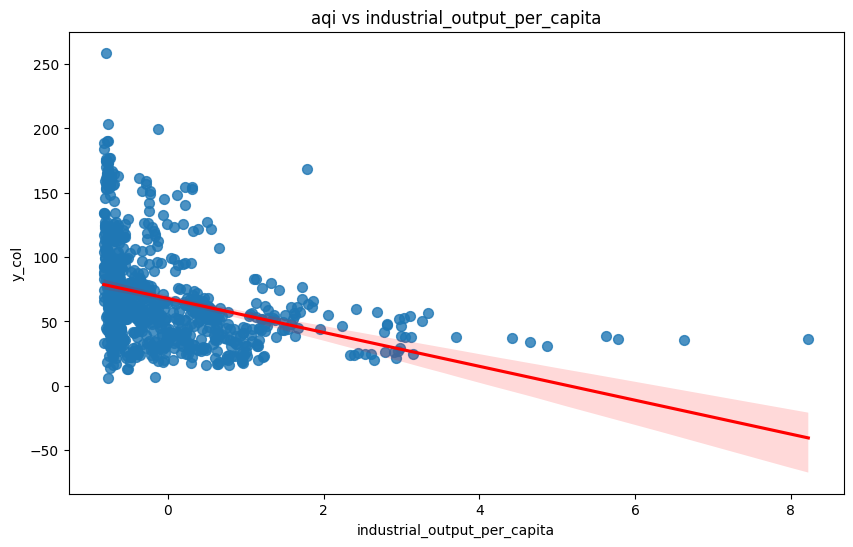

In [150]:
for c in ['population', 'gdp', 'gdp_per_capita', 'growth_rate', 'industrial_output_per_capita']:
    scatter(scaled_df, c, 'aqi')

## Model

We're next going to make a model that aims to predict air quality using our economic data. We'll first try a KNN model, and then a multivariate linear model.

### KNN

We'd like to look for the hyperparameters that make our model as effective as possible. We have only a few parameters to consider:
- n_neighbors: The number of nearest neighbors to consider. Common values are 3, 5, 7, and 9.
- weights: The weight function used in prediction. Options are:
  - 'uniform': All neighbors have equal weight.
  - 'distance': Closer neighbors have more influence.
- metric: The distance metric to use. Options include:
  - 'euclidean': The standard Euclidean distance.
  - 'manhattan': The sum of absolute differences.

#### Sidetracked: Hello Neighbor

What if, instead of trying to predict aqi based on economic data, we were just trying to make as accurate a model as we could? Then, using data about **physically** close countries for a particular location would be very useful, because they, well, share the same air. In this particular application, KNN is even more appealing, because using neighboring data points is what it's all about

**Let's code a function that will let us train a model on an unscaled dataset, with a particular kind of scaling**

In [151]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import math

# Class for easily trying different models
class ModelData:
    def __init__(self, name, modelFactory, hypers) -> None:
        self.name = name
        self.modelFactory = modelFactory
        self.hypers = hypers

    def newModel(self):
        return self.modelFactory()

# function for creating knn with specific k
def knn(k):
    return ModelData("knn", lambda: KNeighborsRegressor(), {
        'knn__n_neighbors': [k],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
    })

# train arbitrary model
def train_model(df, scaler, indep_vars, dep_var, model_data):
    X = df[indep_vars]
    y = df[dep_var]
    # create data pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        (model_data.name, model_data.newModel())
    ])
    # Shoutout to GridSearchCV for hyperparameter tuning (I'm newish to data science and it's so cool that there's a package for everything)
    grid_search = GridSearchCV(pipeline, model_data.hypers, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    # undo our neg mean square
    best_score = math.sqrt(-grid_search.best_score_)
    
    return best_model, best_params, best_score
    

def print_model(best_score, best_params={}):
    if len(best_params) > 0:
        print("Best Hyperparameters:", best_params)
    print("Best Cross-Validation Score:", best_score)


**Let's now get a feel for how knn behaves for different sets of indep variables in our dataset.**

In [152]:
# specific k is not particularly important - we'll optimize that soon
KNN = knn(20)

print("\nALL INDICATORS (k=20):\n")

knn_model, knn_params, knn_score = train_model(all_df, pre.StandardScaler(), indicator_columns, 'aqi', KNN)
print_model(knn_score, knn_params)

print("\nJUST POPULATION (k=20):\n")

pop_model, pop_params, pop_score = train_model(all_df, pre.StandardScaler(), ['population'], 'aqi', KNN)
print_model(pop_score, pop_params)

print("\nJUST LAND AREA (k=20):\n")

land_model, land_params, land_score = train_model(all_df, pre.StandardScaler(), ['land_area'], 'aqi', KNN)
print_model(land_score, land_params)



ALL INDICATORS (k=20):

Best Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'uniform'}
Best Cross-Validation Score: 35.20133530559205

JUST POPULATION (k=20):

Best Hyperparameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 20, 'knn__weights': 'uniform'}
Best Cross-Validation Score: 39.2561524970625

JUST LAND AREA (k=20):

Best Hyperparameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 20, 'knn__weights': 'uniform'}
Best Cross-Validation Score: 40.8889874451524


So our average estimated AQI is 35 points off of the actual, in a range of 0 to 500. We're doing 4 points better with just population, and population is only doing 1 point better than land area, which is a relatively useless metric, so we know for sure that economic data is useful when predicting AQI. Before we look for the best value of k, let's figure out if some of the metrics we're giving the model area actually confusing it. Let's try some combinations of the more useful metrics and see how much better we can make our model. 

**We'll use our analysis from earlier to pick out the valuable metrics, and try all nonempty subsets of them to find the best set of metrics to use for knn.**

In [153]:
from itertools import combinations

def evaluate_model(df, scalers, valuable_indep_vars, dep_var, model):
    best_score = float('inf')
    best_scaler = None
    best_indep_vars = None
    best_model = None
    best_params = None

    subsets = []
    for r in range(1, len(valuable_indep_vars) + 1):
        # create all subsets of size r
        subsets.extend(combinations(valuable_indep_vars, r))
    indep_var_lists = [list(subset) for subset in subsets]

    for indep_vars in indep_var_lists:
        for scaler in scalers:
            # for each combo we're trying, train a new model
            new_model, new_params, new_score = train_model(df, scaler, indep_vars, dep_var, model)
            # if it's better than the current best, update
            if new_score < best_score:
                best_score = new_score
                best_scaler = scaler
                best_indep_vars = indep_vars
                best_model = new_model
                best_params = new_params
    
    return best_scaler, best_indep_vars, best_model, best_params, best_score

In [154]:
# why not try a few different scalers
scalers_to_try = [pre.StandardScaler(), pre.RobustScaler()]
# from our analysis, these were the cool ones
valuable_metrics = ['population', 'growth_rate', 'gdp', 'gdp_per_capita', 'industrial_output_per_capita']
# figure out the best combo of scalers and metrics
best_knn_scaler, best_knn_indep_vars, best_knn_model, best_knn_params, best_knn_score = evaluate_model(all_df, scalers_to_try, valuable_metrics, 'aqi', KNN)

print("\nINDEPENDENT VARS:\n")
print(str(best_knn_indep_vars))
print("\nSCORE:\n")
print_model(best_knn_score, best_knn_params)


INDEPENDENT VARS:

['population', 'growth_rate', 'industrial_output_per_capita']

SCORE:

Best Hyperparameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'uniform'}
Best Cross-Validation Score: 34.54367927377066


Even better! It looks like using just those three columns gives us our most accurate knn model. **Let's try different values of k.**

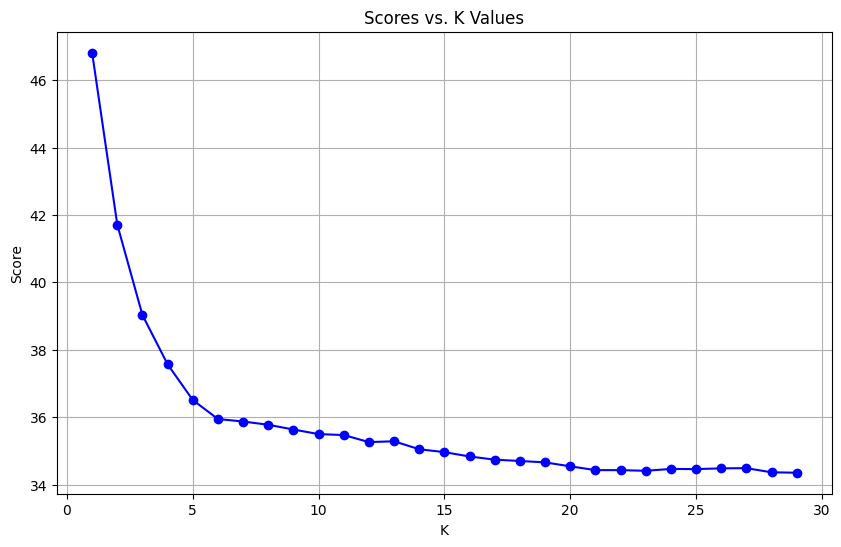

In [155]:
k_values = list(range(1, 30))
scores = [train_model(all_df, best_knn_scaler, best_knn_indep_vars, 'aqi', knn(k))[2] for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o', linestyle='-', color='b')
plt.title('Scores vs. K Values')
plt.xlabel('K')
plt.ylabel('Score')
plt.grid(True)
plt.show()


**It looks like we do really well in the low twenties, say, k=23. Let's try that out and get a final model score.**

In [156]:
_, _, _, _, score =evaluate_model(all_df, scalers_to_try, valuable_metrics, 'aqi', knn(23))
print_model(score)

Best Cross-Validation Score: 34.41096717006501




### Linear Regression

Off the bat, we can deduce without even coding that we're going to need some kind of regularization. Why? There's just **so much bias**. Most of the air quality data comes from small countries whose air quality is easily influenced by the countries around them, and so linearizing something like that down to economic indicators is just not going to work. Any model that doesn't have some regularization is going to give too much weight to the less useful coefficients, and be too noisy.

In [157]:
from sklearn.linear_model import Ridge
# create ridge model with substantial dampening, as there's a LOT of bias
RIDGE = ModelData("linear", lambda: Ridge(1000), {})
#train model and print results
lin_model, _, lin_score = train_model(all_df, pre.StandardScaler(), indicator_columns, 'aqi', RIDGE)
print("\nALL INDICATORS:\n")
print_model(lin_score)
lin_model, _, lin_score = train_model(all_df, pre.StandardScaler(), ['population'], 'aqi', RIDGE)
print("\nJUST POPULATION:\n")
print_model(lin_score)


ALL INDICATORS:

Best Cross-Validation Score: 35.80201427421902

JUST POPULATION:

Best Cross-Validation Score: 37.23592484979809


Already, that's almost as good as our best KNN model! **Let's see if we can find a subset of parameters that is particularly effective.** Linear models train quite quickly, so we can try more parameters

In [158]:
def print_coefficients(indep_vars, pipeline):
    # get our coefficients from the linear step in our pipeline
    model_coeffs = pipeline.named_steps['linear'].coef_
    print("\nCOEFFICIENTS:\n")
    for c, v in zip(indep_vars, model_coeffs):
        print(f'{c}: {v}')


metrics_to_try = valuable_metrics + ['growth_rate_per_capita', 'industrial_output', 'population_density']
best_lin_scaler, best_lin_indep_vars, best_lin_model, best_lin_params, best_lin_score = evaluate_model(all_df, scalers_to_try, metrics_to_try, 'aqi', RIDGE)

print("\nINDEPENDENT VARS:\n")
print(str(best_lin_indep_vars))
print("\nSCORE:\n")
print_model(best_lin_score)
print_coefficients(best_lin_indep_vars, best_lin_model)


INDEPENDENT VARS:

['population', 'growth_rate', 'gdp', 'gdp_per_capita', 'industrial_output_per_capita', 'industrial_output']

SCORE:

Best Cross-Validation Score: 33.48205202471344

COEFFICIENTS:

population: 3.5130687773016187
growth_rate: 3.0461705659166327
gdp: -1.0386330219319713
gdp_per_capita: -3.3196161294662345
industrial_output_per_capita: -3.803989857358781
industrial_output: -0.5281510264025531


That's even better than our knn model! These coefficients are really interesting, and some neat insights can be drawn from them. Let's move on to *analysis*.

## Booth Review

Now's the time where we get to learn from all our hard work. Based on the analysis, it feels appropriate to draw following conclusions about the relationships between economic indicators and air quality (AQI):

1) **Population and Growth Rate**: Higher population and growth rate are associated with increased AQI values, indicating that densely populated and rapidly growing areas tend to experience worse air quality due to higher pollution levels from various sources.

2) **GDP and Industrial Output**: Interestingly, higher GDP and industrial output are associated with lower AQI values. This suggests that wealthier and more industrialized regions might have better air quality controls and cleaner technologies, reducing pollution despite economic activity.

3) **GDP per Capita and Industrial Output per Capita**: Both higher GDP per capita and industrial output per capita correlate with lower AQI values. This further supports the idea that increased economic wealth and efficient industrial practices can mitigate pollution, likely due to better regulations and cleaner production methods.

What makes these insights particularly powerful is the relationships we observed in the exploratory data analysis section were **reaffirmed** by our linear model. So, just by going through the data science pipeline, we were able to get corroborated insights, so to speak.

### What went wrong?

If I redid this, knowing the important role economic per capita metrics played, I would be able to tailor the independent vars to the more air-quality-influential metrics. Additionally, a more powerful model like a [neural net](https://news.mit.edu/2017/explained-neural-networks-deep-learning-0414) might be able to provide even more insight. Overall, though, there's one big thing that's missing: data. 13 years is a relatively short span from an economic or air quality standpoint, and having a longer stretch of time to analyze might give more meaningful insight into **when** and **how** the relationship between economy and AQI changed. Unfortunately, there's just not that much *good, old* data on air quality. On the other hand, people have cared about money forever, so there's lots of good, old economic data.

### Anyways, So... What?

Broadly, these insights highlight the importance of sustainable economic policies that balance growth with environmental protection. Decision-makers can use these findings to promote cleaner technologies and stricter environmental regulations to improve air quality. They serve as almost evidence of a turning point, a source of good news, that we as humans have fought the battle to be wealthy and clean air, and after a lot of decades of losing that battle, we're finally winning. The fact that growth rate is associated with increased AQI means we're not totally out of the woods, yet. It seems like given enough time, we can combat our pollution contributions with money. We stand to learn: Will we someday innovate too quickly for our own good, and outpace our ability to keep our planet clean? Or will we continue to conquer the atmosphere? No one knows for sure, but I have a [feeling](https://learn.kaiterra.com/en/air-academy/air-pollution-solutions-technology) we'll be okay.

Thank you for reading!

# Bonus: Predicting Future AQI

Because there's so much past economic data available, I figured it'd be interesting to see if, for example, last year economic data is helpful for this year's aqi. **I'm simply going to redo the analysis for a series of year offsets, and graph them.**

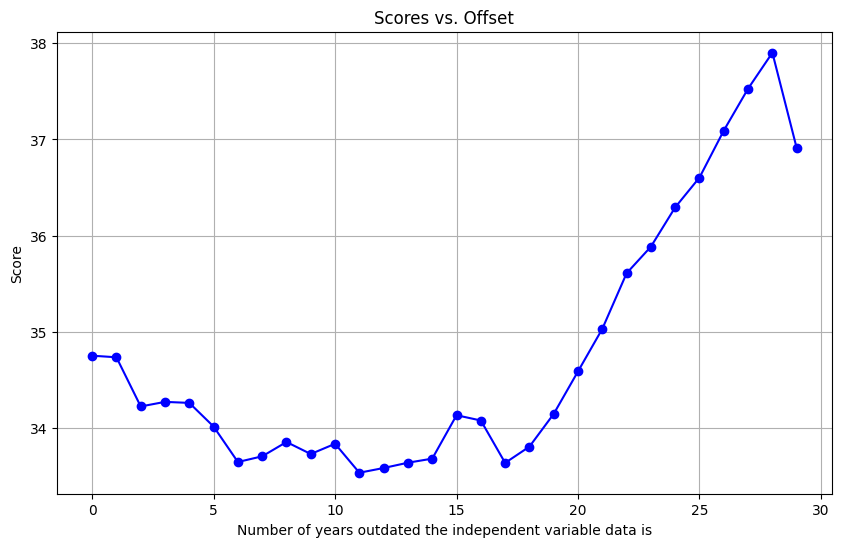

In [159]:
MAX_OFFSET = 30

large_basic_dfs = inner_join_all_on_country_and_year(*[fetch_world_bank_data(INDICATORS[i], i, START_YEAR - MAX_OFFSET, END_YEAR) for i in BASIC_INDICATOR_NAMES])
large_economic_dfs = {i: economic_metrics(INDICATORS[i], i, large_basic_dfs, START_YEAR - MAX_OFFSET, END_YEAR) for i in ECONOMIC_INDICATOR_NAMES}
large_non_aq_df = inner_join_all_on_country_and_year(*large_economic_dfs.values(), large_basic_dfs)

def scoreFromOffset(offset):
    offset_df = large_non_aq_df.assign(year=large_non_aq_df['year'] + offset)
    df = inner_join_all_on_country_and_year(offset_df, aq_df)
    _, _, score = train_model(df, pre.StandardScaler(), best_lin_indep_vars, 'aqi', RIDGE)
    return score


offsets = list(range(0, MAX_OFFSET))
scores = [scoreFromOffset(offset) for offset in offsets]

plt.figure(figsize=(10, 6))
plt.plot(offsets, scores, marker='o', linestyle='-', color='b')
plt.title('Scores vs. Offset')
plt.xlabel('Number of years outdated the independent variable data is')
plt.ylabel('Score')
plt.grid(True)
plt.show()

Fascinatingly, the model seems to be *more* accurate, almost 20 years in advance. That's really interesting, because it makes a real case that economic growth is a good predictor of **future** air quality, and not even necessarily short-term. That's a pretty cool bonus! If you're particularly interested in predicting future air quality, check out [this](https://www.sciencedirect.com/science/article/pii/S235214652200477X) paper. Hope you enjoyed this notebook!